In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
def make_hello(N =1000,rseed=42):
    #Make a plot with Hello
    fig, ax = plt.subplots(figsize=(4,1))
    fig.subplots_adjust(left =0, right=1, top=1, bottom=0)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    #Open PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4*N, 2)
    i, j = (X*data.shape).astype(int).T
    mask = (data[i,j] <1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]



(-0.11881377209280353,
 4.140158966213945,
 0.02958197717253727,
 1.0142039520339077)

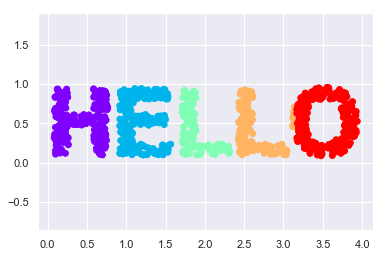

In [3]:
X = make_hello()
colorize= dict(c = X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

### Multidimensional scaling(MDS)

(4.451319934090604, 8.400518093685324, 5.003260986968123, 7.802036607368196)

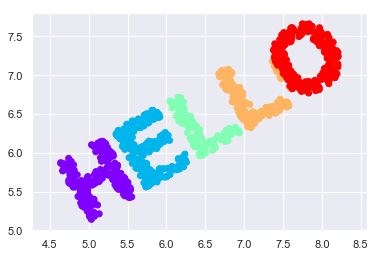

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R  = [[np.cos(theta), np.sin(theta)],
          [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
X2 = rotate(X, 30) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')

This tells us that rotating and scalling do nothing with data.   
X and Y axis are not necessary for describing out data  
это **выделенный** текст


In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape


(1000, 1000)

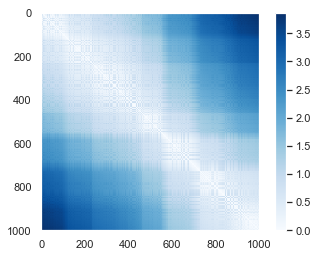

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation = 'nearest')
plt.colorbar()

True


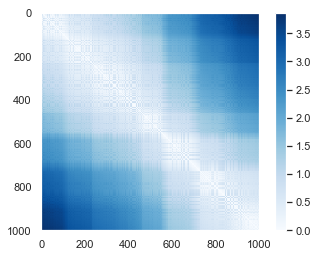

In [7]:
D2 = pairwise_distances(X2)
print(np.allclose(D, D2))
plt.imshow(D2, zorder=2, cmap='Blues', interpolation = 'nearest')
plt.colorbar()

D2 and D the same, becouse we didnot scale ,we only rotate our data

(-1.0390064107727583,
 1.0377133989963168,
 -2.064666005451131,
 2.135458244484912)

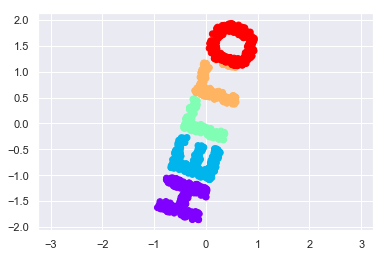

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

In [10]:
def make_hello_s_curve(X):
    t = (X[:,0] - 2) *0.75 * np.pi
    x = np.sin(t)
    y = X[:,1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T
XS = make_hello_s_curve(X)

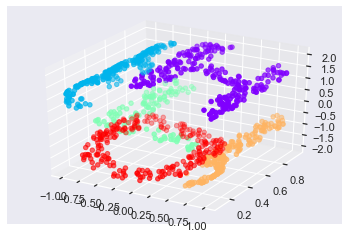

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

(-1.3904556323554296,
 1.2493637628504923,
 -2.3855494181659127,
 2.1899859123555587)

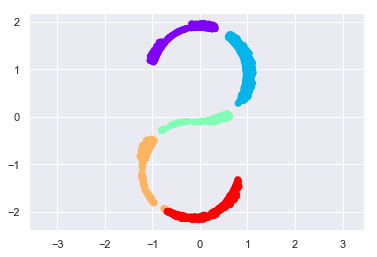

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

IT does not work!!! Becaus nonlinear relation in our data

### Nonlinear Manifolds: Locally Linear Embeddings(LLE)

(0.15, -0.15)

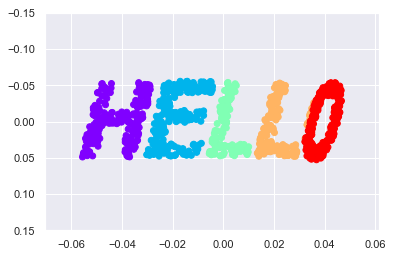

In [17]:
from sklearn.manifold import LocallyLinearEmbedding
# Сохраняет расстояния с ближайшеми соседями
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                              eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

### Example: Isomap on Faces

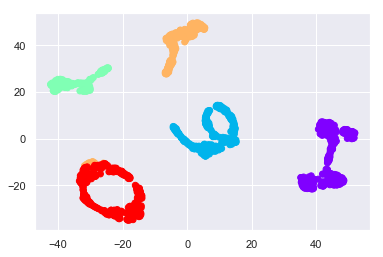

In [23]:
from sklearn.manifold import TSNE
# Сохраняет расстояния с ближайшеми соседями
model = TSNE()
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)


In [27]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape
faces.images.shape

(976, 62, 47)

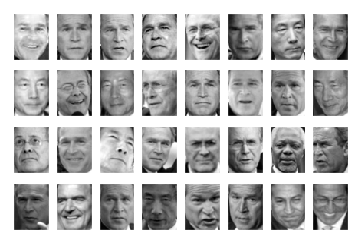

In [29]:
fig, ax = plt.subplots(4,8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'comulative variance')

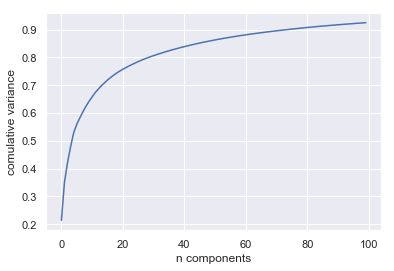

In [39]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('comulative variance')

In [40]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape


(976, 2)

In [63]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                   thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:,0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0)))**2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images)**2, 1)
            if np.min(dist) <min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)
            
    


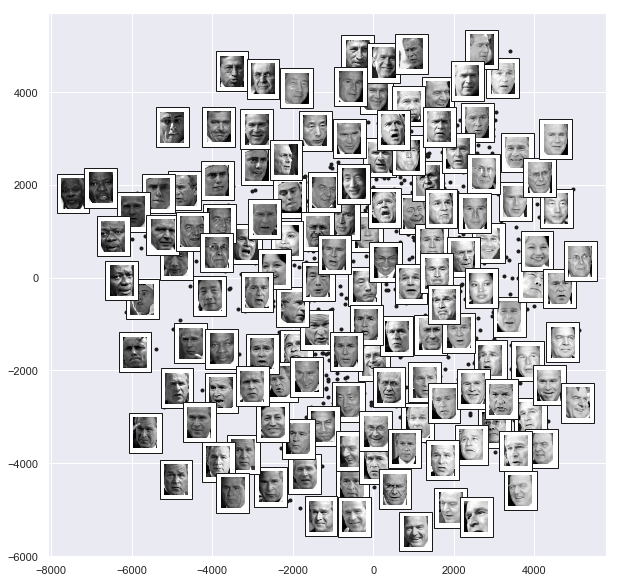

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model = Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

### Example: Visualizing Structure in Digits

In [78]:
from sklearn.datasets import load_digits
mnist = load_digits()
mnist.data.shape

(1797, 64)

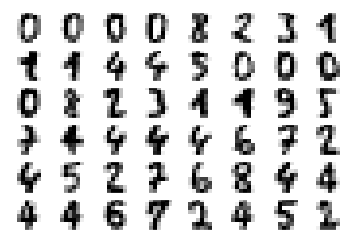

In [79]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[10*i].reshape(8,-1), cmap='gray_r')

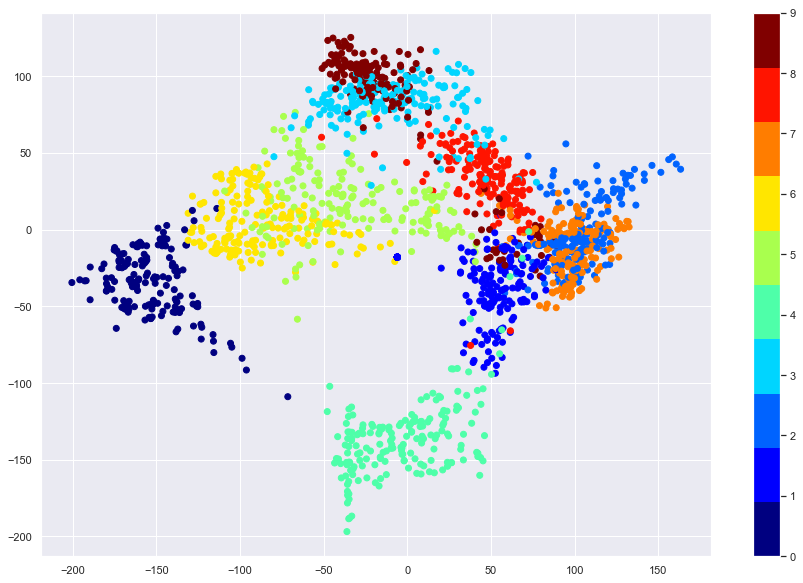

In [88]:
data = mnist.data
target = mnist.target

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.figure(figsize=(15,10))
plt.scatter(proj[:, 0], proj[:, 1], c = target, cmap = plt.cm.get_cmap('jet', 10), marker = 'o')
plt.colorbar(ticks=range(10))


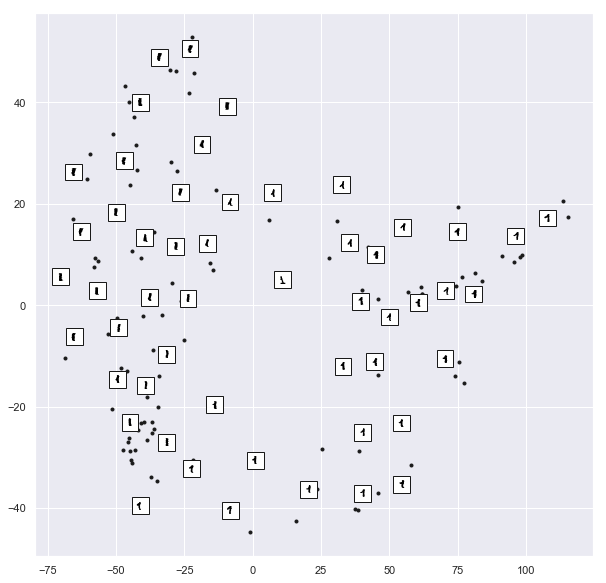

In [96]:
from sklearn.manifold import Isomap

#Choose digits with one label
data = mnist.data[mnist.target == 1]

fig, ax = plt.subplots(figsize = (10, 10))
model = Isomap(n_components=2,eigen_solver='dense')
plot_components(data, model,ax = ax,  images = data.reshape((-1, 8, 8)), cmap = 'gray_r')